## dealing with CASIM output



In [1]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from glob import glob
import seaborn as sns
import xesmf as xe
import pandas as pd
import netCDF4 as nc

## questions / thoughts 
* what units do you want final conc to be in? cm-3 is current
* what do we want students to edit?
* averaging? (everything looks a bit mad)

In [2]:
def open_correct_hr_files(hr):
    file_ending = ['.nc', '_density.nc', '_w.nc']
    file_names = ['hydro', 'density', 'updraft'] # number = hydrometeor values
    nc_file_loc = '/gws/nopw/j04/dcmex/users/dfinney/data/CASIM/dd455_4apr2024_ncs_27feb2025v2/20220730T0000Z/expt1/'
    files_dict = {}
    for i in range(len(file_ending)):
        file = f'{nc_file_loc}20220730T0000Z_LMagda_km1p5set1_expt1_pz0{hr}{file_ending[i]}'
        files_dict[file_names[i]] = xr.load_dataset(file)
    return files_dict

## silly output is sometimes on different grids
def re_grid_stuff(file_to_change, file_correct_grid):
    regridder = xe.Regridder(file_to_change, file_correct_grid, "bilinear")
    corrected_file = regridder(file_to_change)
    return corrected_file

## this is applying to grid_lat and grid_lon - which is different from actual lat + lon
def slice_smaller_domain(dataframe, min_lat, max_lat, min_lon, max_lon):
    sliced_df = dataframe.sel(grid_latitude=slice(min_lat, max_lat), grid_longitude=slice(min_lon, max_lon))
    return sliced_df



    

In [3]:
## this is also just for 1 hr - with 4 * 15 mins
file_dict_16 = open_correct_hr_files('16')
file_dict_17 = open_correct_hr_files('17')

file_dict_16['updraft_regrid'] = re_grid_stuff(file_dict_16['updraft'], file_dict_16['hydro'])
file_dict_17['updraft_regrid'] = re_grid_stuff(file_dict_17['updraft'], file_dict_17['hydro'])


# also need to do orography stuff 
orog = '/gws/nopw/j04/dcmex/users/dfinney/data/CASIM/dd455_4apr2024_ncs_27feb2025v2/20220716T0000Z_LMagda_km1p5set1_expt1_pa000_model_orog.nc'
orography = xr.load_dataset(orog) ## orography over 

orography_regrid = re_grid_stuff(orography, file_dict_17['hydro'])

/tmp/ipykernel_2330519/1007311360.py:8: FutureWarning: In a future version, xarray will not decode the variable 'forecast_period' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  files_dict[file_names[i]] = xr.load_dataset(file)
/tmp/ipykernel_2330519/1007311360.py:8: FutureWarning: In a future version, xarray will not decode the variable 'forecast_period' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of enc

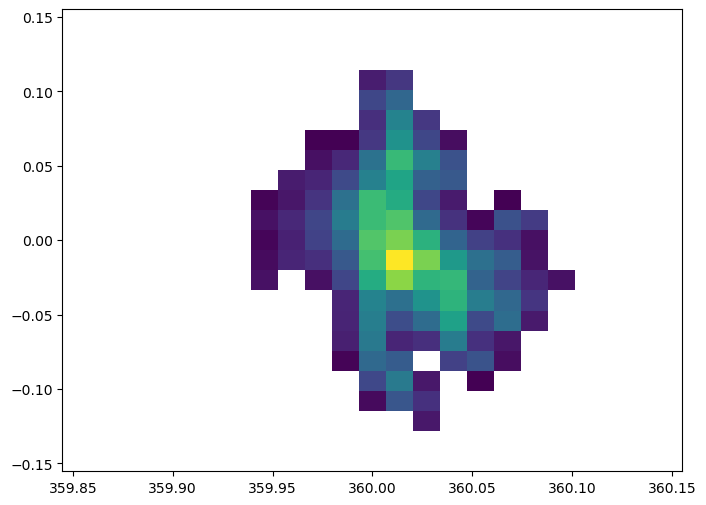

In [4]:
#print(file_dict_16['density']['lon'].min())
#print(file_dict_16['density']['lon'].max())
#file_dict_16['density']

#print(orography)
#print(orography)
#plt.plot(orography['grid_latitude'], orography['grid_longitude'])

'''
plt.figure(figsize=(8,6))
plt.pcolormesh(
    orography["grid_longitude"], 
    orography["grid_latitude"], 
    orography['surface_altitude'], 
    shading="auto", 
    cmap="viridis")
    
#orography

'''

## where alt is higher than 2250m 
alt_mask_n = 2250.0
alt_masked = orography_regrid.where(orography_regrid['surface_altitude'] >= alt_mask_n)
'''
plt.figure(figsize=(8,6))
plt.pcolormesh(
    orography["grid_longitude"], 
    orography["grid_latitude"], 
    alt_masked['surface_altitude'], 
    shading="auto", 
    cmap="viridis")
'''

## alt >2250, and fiddling around with area of lat / lon to plot
#min_lat = -2.025
#max_lat

## ive just fiddled around with different numbers until I think it is directly over the mountain
# could also do min long as 359.88 - so plots square, but this is close to mountain as pos
min_lat = -0.15
max_lat = 0.15

min_lon = 359.85
max_lon = 360.15

orog_subset = alt_masked.sel(grid_latitude=slice(min_lat, max_lat), grid_longitude=slice(min_lon, max_lon))

## different approach for getting smaller domain:
'''lat_mask = (alt_masked['grid_latitude'] >= min_lat) & (alt_masked['grid_latitude'] <= max_lat)
lon_mask = (alt_masked['grid_longitude'] >= min_lon) & (alt_masked['grid_longitude'] <= max_lon)

lat_mask_4d = lat_mask.expand_dims(time=file_dict_16['hydro'].time)
lon_mask_4d = lon_mask.expand_dims(time=file_dict_16['hydro'].time)

orog_subset = alt_masked.where(lat_mask & lon_mask, drop=True)
'''
plt.figure(figsize=(8,6))
plt.pcolormesh(
    orog_subset["grid_longitude"], 
    orog_subset["grid_latitude"], 
    orog_subset['surface_altitude'], 
    shading="auto",
    cmap="viridis")

In [5]:
#file_dict_16['density']

## slice so domain is lot smaller:
subset_file_17 = {}
for key in file_dict_17:
    data = file_dict_17[key]
    
    subset = slice_smaller_domain(data, min_lat, max_lat, min_lon, max_lon)    
    subset_file_17[key] = subset

## only the data has lat / lon coords

## slice the alt data as well
orog_subset = slice_smaller_domain(orography_regrid, min_lat, max_lat, min_lon, max_lon)  

In [8]:
#print(subset_file_16['hydro'])#['sigma'] 
# if want to pull out 1 time
t0_subset_file_16_hydro = subset_file_16['hydro'].isel(time=0) # 0 / 1 / 2 / 3 


NameError: name 'subset_file_16' is not defined

In [6]:
# the level_height is not very informative, we can create real altASL from level_height and sigma (silly model thing - model level vary with altitude)
# and take into account the orography of the land
altASL = subset_file_17['hydro']['level_height'] + subset_file_17['hydro']['sigma'] *  orog_subset['surface_altitude']
altASL ## this is also for 1 time step 

## grid lat / lon are not normal lat /lon - lat  + lon varies in 3d space  ## this can be dealt with at a later time

<xarray.DataArray (model_level_number: 70, grid_latitude: 23, grid_longitude: 23)> Size: 148kB
array([[[ 2147.9402,  2011.3405,  1941.6855, ...,  1730.8898,
          1701.8091,  1687.2502],
        [ 2180.9019,  2084.7905,  1958.5455, ...,  1766.0073,
          1727.8165,  1732.3334],
        [ 2102.904 ,  2036.5171,  1954.6713, ...,  1789.951 ,
          1752.9481,  1724.3314],
        ...,
        [ 2151.6094,  2114.9385,  2095.6184, ...,  1805.3936,
          1843.3248,  1843.6998],
        [ 2155.113 ,  2113.8257,  2081.8652, ...,  1828.2845,
          1863.3396,  1857.8474],
        [ 2169.1802,  2123.7822,  2080.9219, ...,  1844.2562,
          1884.1035,  1884.9731]],

       [[ 2160.4912,  2024.1539,  1954.6328, ...,  1744.2418,
          1715.217 ,  1700.6862],
        [ 2193.3896,  2097.463 ,  1971.4603, ...,  1779.2919,
          1741.1746,  1745.6826],
        [ 2115.5417,  2049.2822,  1967.5935, ...,  1803.1897,
          1766.2578,  1737.696 ],
...
        [35845.004 , 35845.004 , 35845.004 , ..., 35845.004 ,
         35845.004 , 35845.004 ],
        [35845.004 , 35845.004 , 35845.004 , ..., 35845.004 ,
         35845.004 , 35845.004 ],
        [35845.004 , 35845.004 , 35845.004 , ..., 35845.004 ,
         35845.004 , 35845.004 ]],

       [[40000.    , 40000.    , 40000.    , ..., 40000.    ,
         40000.    , 40000.    ],
        [40000.    , 40000.    , 40000.    , ..., 40000.    ,
         40000.    , 40000.    ],
        [40000.    , 40000.    , 40000.    , ..., 40000.    ,
         40000.    , 40000.    ],
        ...,
        [40000.    , 40000.    , 40000.    , ..., 40000.    ,
         40000.    , 40000.    ],
        [40000.    , 40000.    , 40000.    , ..., 40000.    ,
         40000.    , 40000.    ],
        [40000.    , 40000.    , 40000.    , ..., 40000.    ,
         40000.    , 40000.    ]]], shape=(70, 23, 23), dtype=float32)
Coordinates:
  * model_level_number       (model_level_number) int32 280B 1 2 3 ... 68 69 70
  * grid_latitude            (grid_latitude) float32 92B -0.1485 ... 0.1485
  * grid_longitude           (grid_longitude) float64 184B 359.9 359.9 ... 360.1
    forecast_reference_time  datetime64[ns] 8B 2022-07-30
    level_height             (model_level_number) float32 280B 5.0 ... 4e+04
    sigma                    (model_level_number) float32 280B 0.9994 ... 0.0
    forecast_period          timedelta64[ns] 8B 00:00:00
    time                     datetime64[ns] 8B 2022-07-16
    lon                      (grid_latitude, grid_longitude) float64 4kB -107...
    lat                      (grid_latitude, grid_longitude) float64 4kB 33.8...

In [7]:
## now we want to mask values which are below a certain altitude (altASL)
# !! if want to do it across multiple times -> need to expand the dimentions
'''
altASL_4d = altASL.expand_dims(time=subset_file_16['hydro'].time) # thank god for xarray broadcasting
'''

# we do the usual >6000m - if we just stick to 1 time step
# we choose what height above sea level to mask 
mask_asl = altASL  > 6000
#mask3d = mask['surface_altitude']

# also want to mask where updrafts are > 2m/s
# again just do to 1 time step
'''
updraft_16_t0 = subset_file_16['updraft_regrid'].isel(time=0) # 0 / 1 / 2 / 3 
mask_w = updraft_16_t0['upward_air_velocity'] > 0 # this seems to be a strong limiting factor
'''
updraft_17_t0 = subset_file_17['updraft_regrid'].isel(time=0) # 0 / 1 / 2 / 3 
mask_w = updraft_17_t0['upward_air_velocity'] > 0 # this seems to be a strong limiting factor

## combine mask 
combined_mask = mask_asl & mask_w # & = both conditions must be true to keep values // | = either condition to be true


## and apply it
file_names_key = ['hydro', 'density']


# just going to test out on 1 time step
#for i in range(2):
    

#alt_masked
'''
file_16_hydro_masked_both = t0_subset_file_16_hydro.where(combined_mask)
file_16_hydro_masked_w = t0_subset_file_16_hydro.where(mask_w)
file_16_hydro_masked_alt = t0_subset_file_16_hydro.where(mask_asl)
'''

#file_17_hydro_masked_both = t0_subset_file_17_hydro.where(combined_mask)
#file_17_hydro_masked_w = t0_subset_file_17_hydro.where(mask_w)
#file_17_hydro_masked_alt = t0_subset_file_17_hydro.where(mask_asl)


## going to do some masking + put in dic
def masking_a_dict(a_dict, mask, dict_keys):
    new_dict = {}
    for key in dict_keys:
        data = a_dict[key]
        masked = data.where(mask)
        new_dict[key] = masked
    
    return new_dict

# time v - 0 / 1 / 2 / 3  ={corresponds}=>  00 / 15 / 30 / 45 past hr
def select_time(a_dict, time_v):
    a_time_dict = {}
    for key in a_dict:
        data = a_dict[key]
        a_time_dict[key] = data.isel(time=time_v)
    return a_time_dict

'''
masked_w_dict_16 = masking_a_dict(select_time(subset_file_16, 0), mask_w, file_names_key)
masked_alt_dict_16 = masking_a_dict(select_time(subset_file_16, 0), mask_asl, file_names_key)
masked_both_dict_16 = masking_a_dict(select_time(subset_file_16, 0), combined_mask, file_names_key)
'''
masked_w_dict_17 = masking_a_dict(select_time(subset_file_17, 0), mask_w, file_names_key)
masked_alt_dict_17 = masking_a_dict(select_time(subset_file_17, 0), mask_asl, file_names_key)
masked_both_dict_17 = masking_a_dict(select_time(subset_file_17, 0), combined_mask, file_names_key)
 

In [8]:
file_dict_16['hydro']

<xarray.Dataset> Size: 2GB
Dimensions:                                           (time: 4,
                                                       model_level_number: 70,
                                                       grid_latitude: 300,
                                                       grid_longitude: 300)
Coordinates:
  * time                                              (time) datetime64[ns] 32B ...
  * model_level_number                                (model_level_number) int32 280B ...
  * grid_latitude                                     (grid_latitude) float32 1kB ...
  * grid_longitude                                    (grid_longitude) float64 2kB ...
    forecast_reference_time                           datetime64[ns] 8B 2022-...
    forecast_period                                   (time) timedelta64[ns] 32B ...
    level_height                                      (model_level_number) float32 280B ...
    sigma                                             (model_level_number) float32 280B ...
    lon                                               (grid_latitude, grid_longitude) float64 720kB ...
    lat                                               (grid_latitude, grid_longitude) float64 720kB ...
Data variables: (12/16)
    number_of_cloud_droplets_per_kg_of_air            (time, model_level_number, grid_latitude, grid_longitude) float32 101MB ...
    number_of_rain_drops_per_kg_of_air                (time, model_level_number, grid_latitude, grid_longitude) float32 101MB ...
    number_of_ice_particles_per_kg_of_air             (time, model_level_number, grid_latitude, grid_longitude) float32 101MB ...
    number_of_snow_aggregates_per_kg_of_air           (time, model_level_number, grid_latitude, grid_longitude) float32 101MB ...
    number_of_graupel_particles_per_kg_of_air         (time, model_level_number, grid_latitude, grid_longitude) float32 101MB ...
    cloud_volume_fraction_in_atmosphere_layer         (time, model_level_number, grid_latitude, grid_longitude) float32 101MB ...
    ...                                                ...
    air_temperature                                   (time, model_level_number, grid_latitude, grid_longitude) float32 101MB ...
    mass_fraction_of_cloud_ice_in_air                 (time, model_level_number, grid_latitude, grid_longitude) float32 101MB ...
    mass_fraction_of_cloud_liquid_water_in_air        (time, model_level_number, grid_latitude, grid_longitude) float32 101MB ...
    mass_fraction_of_graupel_in_air                   (time, model_level_number, grid_latitude, grid_longitude) float32 101MB ...
    mass_fraction_of_rain_in_air                      (time, model_level_number, grid_latitude, grid_longitude) float32 101MB ...
    specific_humidity                                 (time, model_level_number, grid_latitude, grid_longitude) float32 101MB ...
Attributes: (12/14)
    um_suite:          u-dd455@281404
    casim_branches:    https://code.metoffice.gov.uk/trac/monc/browser/casim/...
    um_branches:       https://code.metoffice.gov.uk/trac/um/browser/main/bra...
    creator_contact:   Declan Finney (d.l.finney@leeds.ac.uk), University of ...
    title:             Simulations over the southwest USA for the DCMEX campa...
    institution:       Generated on UK Met Office Monsoon computing facility,...
    ...                ...
    coord_system:      RotatedGeogCS(56.0, 72.80000305175781, ellipsoid=GeogC...
    conventions:       CF-1.7
    expt_name:         ctl
    NCO:               netCDF Operators version 5.2.7 (Homepage = http://nco....
    history:           Fri Feb 28 14:49:10 2025: ncatted -O -a expt_descripti...
    expt_description:  Control experiment using 250E6 kg-1 fixed droplet numb...

In [9]:
#masked_both_dict_16['density']#['number_of_graupel_particles_per_kg_of_air']
graupel_n = masked_both_dict_17['hydro']['number_of_graupel_particles_per_kg_of_air'] # kg-1
graupel_m = masked_both_dict_17['hydro']['mass_fraction_of_graupel_in_air'] # kg-1

## !!!! basic nc -> number = kg-1 units, use air density (kg m-3) -> kg-1 * kg m-3 = m-3 units
## !!!! basic nc -> mass = kg kg-1 units, use air density (kg m-3) -> kg kg-1 * kg m-3 = kg m-3 units

#convert to m-3
air_density = masked_both_dict_17['density']['Density used for rad layers (kg m-3)']

graupel_m_m3 = graupel_m * air_density
graupel_n_m3 = graupel_n * air_density

### Xinyi code for lambda calculation 

In [10]:
from scipy.special import gamma
from scipy.special import gammainc, gammaincc, gdtr

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Function for model gamma function in (m-3 m-1)
# x = diameter, n = number conc, mu = mu, lambda = lambda (needs calculating)
def model_gamma_pdf(x,n,mu,lamda):
    n0 = (n) * (lamda**(1+mu)) / (gamma(1+mu)) # directly pulled from field paper - (A2)
    N = n0 * (x**mu) * (np.exp(-lamda*x)) 
    return N

### Function for using scipy.special.gdtr to calculate the gamma distribution cumulative distribution function
### I don't like this because in the gdtr you have to switch the order of mu and lambda :(
def model_gamma_cdf(x,n,mu,lam):
    return n*gdtr(lam,1+mu,x)

### Function for integral over the lower and upper limits of the gamma PDF
def partial_integral_gamma(n,mu,lam,lower,upper):
    lower_inc = gammainc(1+mu,lam*lower)
    upper_inc = gammainc(1+mu,lam*upper)
    return n*(upper_inc-lower_inc)

## Function for calculating lamda from mass and number
## with prescribed model number + mass (+ specify type of hydrometeor), lambda can be calculated - to work out distribution
def calc_lambda(model_mass,model_num,hydro):
    # Read in gamma PDF values (Field et al., 2023, Table 1)
    mu = hydroparameters[hydro][0]
    c = hydroparameters[hydro][1]
    d = hydroparameters[hydro][2]
    
    gamma_ratio = gamma(1+mu+d) / gamma(1+mu)
    nm_ratio = model_num / model_mass
    if d == 2:
        lam = np.sqrt(c*nm_ratio*gamma_ratio)
    elif d == 3:
        lam = np.cbrt(c*nm_ratio*gamma_ratio)
    else:
        print("Woohoo, something is wrong here for the moment value!")
        lam = np.nan
    return lam

In [11]:
### Ditionary contains mu, mass-dimention (a,b)
hydroparameters = {'liquid':[2.5,522,3],
                   'rain':[2.5,522,3],
                   'ice':[2.5,np.pi*200/6,3],
                   'snow':[2,0.026,2],
                   'graupel':[2.5,np.pi*500/6,3]}

In [12]:
hydro='graupel'
#n = 120e6 # m-3
#m = 0.0003 # kg m-3
mu = hydroparameters[hydro][0]
lam = calc_lambda(graupel_m_m3, graupel_n_m3 ,hydro) # ! nice ! i think it has broadcasted across 3d space!
#print(mu,lam)


In [13]:
mean_lam_00 = lam.mean(skipna=True).item()
min_lam_00 = lam.min(skipna=True).item()
max_lam_00 = lam.max(skipna=True).item()

mean_g_n_m3 = graupel_n_m3.mean().values
mean_lam_00

# doing it per model level
lam_mean_per_level = lam.mean(dim=("grid_latitude", "grid_longitude"), skipna=True)
mean_g_n_m3_per_level = graupel_n_m3.mean(dim=("grid_latitude", "grid_longitude"), skipna=True)

## actually, i think we would be best to do average lambda per height above sea level

0.0


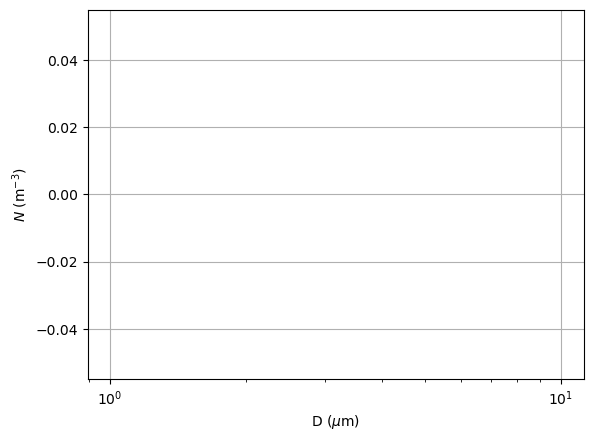

In [14]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()

bins = np.arange(10,1010,10)*1e-6

ax1.plot(bins*1e6,
         model_gamma_pdf(bins,mean_g_n_m3,mu,mean_lam_00)/1e3)
ax1.grid(True)

'''
ax2.plot(bins*1e6,
         model_gamma_cdf(bins,n,mu,lam)/1e3,
         color='k')

## Just to check that they are the same
ax2.scatter(100,n*gammainc(1+mu,lam*100e-6)/1e3)
ax2.scatter(100,model_gamma_cdf(100e-6,n,mu,lam)/1e3,
            marker='s',facecolor='none',edgecolor='C0',
            s=90)

ax2.scatter(1000,n*gammainc(1+mu,lam*1000e-6)/1e3)
ax2.scatter(1000,model_gamma_cdf(1000e-6,n,mu,lam)/1e3,
            marker='s',facecolor='none',edgecolor='C1',
            s=90)
'''
print(partial_integral_gamma(mean_g_n_m3,mu,mean_lam_00,300e-6,1280e-6))
#print((model_gamma_cdf(1000e-6,n,mu,lam) - model_gamma_cdf(100e-6,n,mu,lam))/1e3)

ax1.set_ylabel('$N$ (m$^{-3}$)')
ax1.set_xlabel('D ($\mu$m)')
# ax1.set_yscale('log')
ax1.set_xscale('log')

In [15]:
## we want to know the total conc of graupel as function of alt
## this is per m-3 
level_total_conc = partial_integral_gamma(mean_g_n_m3_per_level,mu,lam_mean_per_level,300e-6,1280e-6)


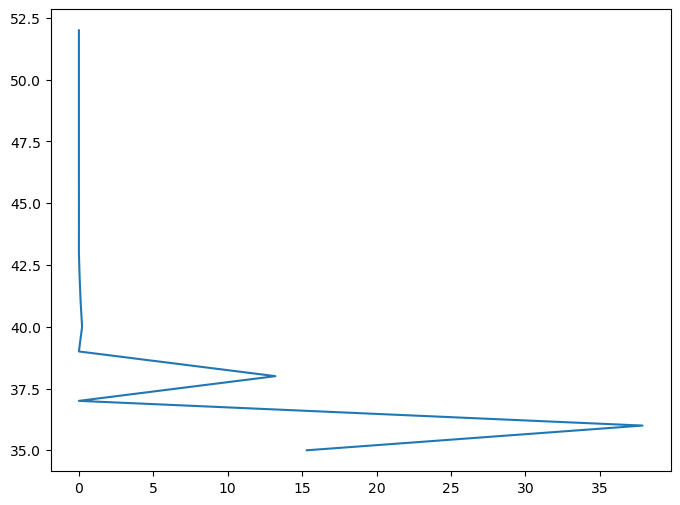

In [22]:
plt.figure(figsize=(8,6))
plt.plot(level_total_conc.values, level_total_conc['model_level_number'])
# x = mean conc -m3 and y = model level

In [16]:
## possibly need to do it per altASL average conc calc - not model_level_number
hydro='graupel'
#n = 120e6 # m-3
#m = 0.0003 # kg m-3
mu = hydroparameters[hydro][0]
lam = calc_lambda(graupel_m_m3, graupel_n_m3 ,hydro) # ! nice ! i think it has broadcasted across 3d space!
#print(mu,lam)



## okay we create set of bins to group levels into 

height_bins = np.arange(6000, 10000, 100)
#print(height_bins[0])
#print(height_bins[1])

min_2ds_size = 300e-6
max_2ds_size = 1280e-6


# need to make a mask for each height interested in 
final_slice_average = []
for i in range(len(height_bins) -1):
    bin0 = height_bins[i]
    bin1 = height_bins[i+1]
    height = (bin0 + bin1)/2
    asl_mask = (altASL  >= bin0) & (altASL  < bin1)
    height_g_n = graupel_n.where(asl_mask)
    height_g_m = graupel_m.where(asl_mask)
    
    # in m3 please 
    height_g_n_m3 =  height_g_n * air_density
    height_g_m_m3 =  height_g_m * air_density
    

    # then can do lambda calc for this level + find its average etc etc
    height_lam = calc_lambda(height_g_m_m3, height_g_n_m3 ,hydro) # ! nice ! i think it has broadcasted across 3d space!

    lam_mean_height = height_lam.mean(skipna=True) # no clue of shape, so just whatever is at that level
    mean_g_n_m3_height = height_g_n_m3.mean(skipna=True)
    std_g_n_m3_height = height_g_n_m3.std(skipna=True)
    

    # then we do total calc of particles # !! based on the average values
    total_conc_avg = (partial_integral_gamma(mean_g_n_m3_height,mu,lam_mean_height, min_2ds_size, max_2ds_size)/1e6)
    
    slice_avg = {'height' : height, 'mean_lam':  lam_mean_height.item(), 'mean_conc':total_conc_avg.item(), 'std_conc':std_g_n_m3_height.item()}
    final_slice_average.append(slice_avg)

model_height_variation = pd.DataFrame(final_slice_average)


    

In [17]:
model_height_variation#['mean_lam']#[0]

,height,mean_lam,mean_conc,std_conc
0,6050.0,inf,0.000000e+00,59.352970
1,6150.0,inf,0.000000e+00,18.820589
2,6250.0,1.295083e+04,5.634838e-06,192.808029
3,6350.0,2.400428e+04,2.461626e-07,40.103630
4,6450.0,2.131266e+04,2.316876e-06,371.443024
5,6550.0,3.759566e+04,1.688691e-08,66.454079
6,6650.0,3.046334e+04,6.137375e-07,680.889343
7,6750.0,3.565247e+04,4.238652e-08,98.880882
8,6850.0,3.454951e+04,2.692742e-07,723.814636
9,6950.0,3.722521e+04,5.259964e-08,157.582901


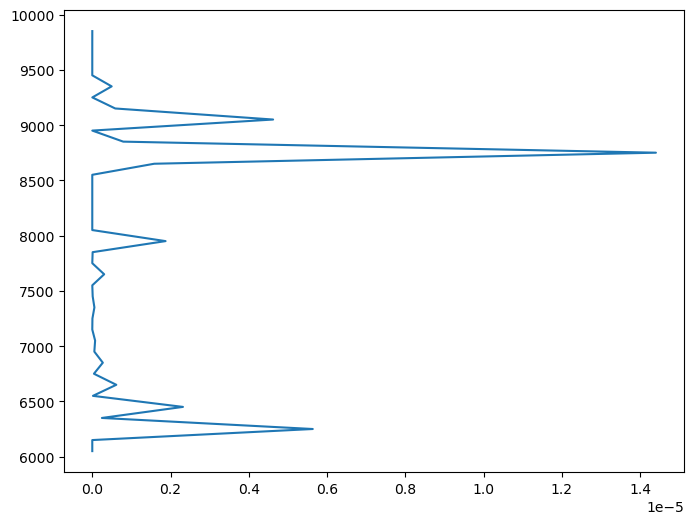

In [19]:
plt.figure(figsize=(8,6))
plt.plot(model_height_variation['mean_conc'], model_height_variation['height'])
# x = mean conc -m3 and y = model level

In [ ]:
## things for students to change?
# size of bin for model average at each height? 

## obs

In [17]:
import sys
# actually, pull in functions i have written previously
sys.path.append('/home/users/esree/phd_plots/paper1_figs/')
from shared_functions import pull_files_together, cloud_pass_time, cnn_labelled_df

# again, another useful function
sys.path.append('/home/users/esree/dcmex_instruments/general-non-image/functions/')
from aimms_data import get_nc_variable, mask_data, flatten_20hz_variable

ds_path = '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/v3_conc/' # different paths, as accounted for HPC in v3 - only 2ds
hvps_path = '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/v2_conc/' 
manc_file_loc = '/home/users/esree/dcmex_instruments/co-located-files/manc_ice_files.json' # 2ds + hvps paired for a date (also has faam too - for TAS adjustment)

full_data_dict = pull_files_together(ds_path, hvps_path, manc_file_loc)

day_dict = full_data_dict['220730']
ch0_df, ch1_df, hvps_df = cnn_labelled_df(day_dict)
start_time, end_time = cloud_pass_time(day_dict) # fabulous function made earlier, get pass start / end times

ch0_cp = ch0_df[ch0_df['habit'] == 'CP']
ch1_cp = ch1_df[ch1_df['habit'] == 'CP']
ch0_cp


,second,count,habit,mean_volume_cm3_s,conc,dNdd,bin_mid,LWC,IWC,w,pres,alt,temp
0,2022-07-30 16:51:13,1.000000,CP,8209.589787,0.000122,0.000012,320.0,0.000000,0.000000,-0.146500,483.49713,6161.4136,265.07310
1,2022-07-30 16:55:31,1.000000,CP,8101.268784,0.000123,0.000012,380.0,0.000000,0.015606,0.345500,503.32050,5846.4880,267.72820
3,2022-07-30 16:55:35,1.000000,CP,7051.534182,0.000142,0.000014,450.0,0.020194,0.000000,-0.909500,503.61404,5844.3955,267.55670
8,2022-07-30 17:00:11,1.000000,CP,2499.812233,0.000400,0.000040,310.0,1.061989,0.000000,4.764501,503.28857,5851.2180,265.96463
9,2022-07-30 17:00:12,1.000000,CP,2330.363146,0.000429,0.000043,320.0,1.251485,0.000000,4.764501,503.28857,5851.2180,265.96463
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,2022-07-30 19:16:01,0.881239,CP,1496.731047,0.000589,0.000059,460.0,1.198988,0.015926,-2.605000,442.41907,6852.4190,260.38820
1022,2022-07-30 19:16:03,0.881239,CP,2882.766424,0.000306,0.000031,370.0,0.680418,0.012855,-4.717000,442.56326,6851.8354,260.49005
1025,2022-07-30 19:16:09,0.881239,CP,8414.300204,0.000105,0.000010,310.0,0.000000,0.005504,0.256000,443.79907,6827.3154,260.46823
1027,2022-07-30 19:16:14,1.000000,CP,7850.057292,0.000127,0.000013,360.0,0.279339,0.015167,-0.368500,443.86290,6824.4090,260.51328


In [45]:
specif_passes = zip(start_time[5:9], end_time[5:9]) # only use specif passes

## make a dict of passes + build from there
pass_dict = {} 

for start_s, end_s in specif_passes:
    start_str = f'{str(start_s)[11:13]}{str(start_s)[14:16]}'
    start_s = start_s.replace(microsecond=0)
    end_s = end_s.replace(microsecond=0) # just going to remove the microseconds, its fine

    pass_dict[start_str] = {}
    pass_dict[start_str]['sec_list'] = pd.date_range(start=start_s, end=end_s, freq='S') #


In [ ]:

w_file = day_dict['aircraft_files'][1]
## need a bit of work from going raw nc core-cloud-phy_faam -> usuable w 
unit, longname, raw_var = get_nc_variable(w_file, 'aimms_w', 'aimms', time = True)
# also need masking bad data 
_, _, flag_values = get_nc_variable(w_file, 'aimms_flag', 'aimms')
raw_var_masked = mask_data(raw_var, flag_values)
# also need to flatten it out - 20hz
raw_var, var_time = flatten_20hz_variable(raw_var_masked) ## raw_var == usable w!

# this is quite inefficient, i dont care - would be better to select out all corresponding seconds at once, then divy up?
#def pull_out_w_sec(w_file):
    
for pass_time in pass_dict:
    second_list = pass_dict[pass_time]['sec_list']

    pass_list = []
    for second in second_list:
        correspond_w = raw_var.sel(time = second).item()

        # get the calculated conc too
        ch0_second_df = ch0_cp[ch0_cp['second'] == second]
        ch1_second_df = ch1_cp[ch1_cp['second'] == second]

        ch0_conc = ch0_second_df['conc'].sum()
        ch1_conc = ch1_second_df['conc'].sum()

        pass_list.append({'second': second, 'w': correspond_w, 'ch0_conc': ch0_conc, 'ch1_conc': ch1_conc})
    pass_df = pd.DataFrame(pass_list)
    pass_dict[pass_time]['df'] = pass_df






In [ ]:
## now need to do the average over 10s - can just add onto the other loop + do it in one
names = ['1659', '1704']
for pass_time in pass_dict:
    df = pass_dict[pass_time]['df']
    total_sec = len(df)
    ## going to have to do some logic
    whole_10 = total_sec % 10
    if whole_10 == 0:
        #print(f'{pass_time} whole 10! {whole_10}')
        factor_of_10 = total_sec
        # that will be an easy job
    # remainders, if divisable by 2, just take off however many
    else:
        even_remainder = whole_10 % 2

        if even_remainder == 0:
            # fine, take the whole_10 / 2 - and can slice off 
            start_deduct = whole_10/2
            end_deduct = whole_10/2
            factor_of_10 = total_sec - whole_10

        else:
            even_deduct = whole_10 - even_remainder
            start_deduct = even_deduct / 2
            end_deduct = even_deduct / 2 + even_remainder # just deduct extra 
            factor_of_10 = total_sec - even_deduct - even_remainder
        # now we just ignore a couple rows, to make nice averages over 10
        df = df[int(start_deduct) : -int(end_deduct)]

    avg_10s_row = []
    final_len = factor_of_10 -9
    for i in range(0, final_len, 10):
        avg_df = df[i:i+10]
        first_sec = avg_df['second'].iloc[0] # just use this 
        avg_10s_row.append({'second': first_sec, 
                            'mean_w': avg_df['w'].mean(),
                            'ch0_mean_conc': avg_df['ch0_conc'].mean(),
                            'ch1_mean_conc': avg_df['ch1_conc'].mean()})
    
    mean_10s_df = pd.DataFrame(avg_10s_row)
    pass_dict[pass_time]['10s_mean'] = mean_10s_df
# this is doing what we want, now we need to make a histogram comparing them

1659 even remainder! 0, 10 = 2
1704 odd remainder! 1, 10 = 5
1715 even remainder! 0, 10 = 4


In [51]:
pass_dict['1659']['10s_mean']

#for key in pass_time:

df_list = [pass_dict[key]['10s_mean'] for key in pass_dict]
#df_list = [df for df in pass_dict[pass_time]['10s_mean']]
four_passes_df = pd.concat(df_list, ignore_index=True)
four_passes_df

,second,mean_w,ch0_mean_conc,ch1_mean_conc
0,2022-07-30 16:59:51,0.146,0.000000,0.000000
1,2022-07-30 17:00:01,2.072,0.000000,0.000013
2,2022-07-30 17:00:11,1.162,0.000227,0.000462
3,2022-07-30 17:00:21,-0.107,0.000150,0.000036
4,2022-07-30 17:04:27,1.365,0.000014,0.000000
5,2022-07-30 17:04:37,7.762,0.000000,0.000085
6,2022-07-30 17:04:47,3.023,0.000474,0.000453
7,2022-07-30 17:04:57,-1.678,0.002054,0.002098
8,2022-07-30 17:05:07,-2.126,0.000114,0.000029
9,2022-07-30 17:05:17,-4.128,0.000000,0.000000


In [40]:
## instrument 2 channels
"""
base_path = '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/v3_conc/'
ch0_loc = 'ch0/22073015_ch0_global_habits.csv'
ch1_loc = 'ch1/22073015_ch1_global_habits.csv'

ch0 = pd.read_csv(base_path+ch0_loc)
ch0['second'] = pd.to_datetime(ch0['second'])


# actually, i have not filtered the data by updraft
only_cp_ch0 = ch0[(ch0['habit'] == 'CP') & (ch0['bin_mid']>= 300) & (ch0['bin_mid']<= 1280)]
only_cp_ch0
"""

"\nbase_path = '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/v3_conc/'\nch0_loc = 'ch0/22073015_ch0_global_habits.csv'\nch1_loc = 'ch1/22073015_ch1_global_habits.csv'\n\nch0 = pd.read_csv(base_path+ch0_loc)\nch0['second'] = pd.to_datetime(ch0['second'])\n\n\n# actually, i have not filtered the data by updraft\nonly_cp_ch0 = ch0[(ch0['habit'] == 'CP') & (ch0['bin_mid']>= 300) & (ch0['bin_mid']<= 1280)]\nonly_cp_ch0\n"

In [41]:
## how to do model / obs comparison - to do +/- 5 mins either size of model output + average over?
# yeah
#model_time = graupel_n.time.values
#mins_buffer = 5 # will +/- either side of model time to get best obs - model comparison
#timedelta = np.timedelta64(mins_buffer, 'm')

#min_obs_time = model_time - timedelta
#max_obs_time = model_time + timedelta
#np.datetime64('2022-07-30T16:15:00.000000000')


#corresponding_time_df = only_cp_ch0[(only_cp_ch0['second'] >= min_obs_time) & (only_cp_ch0['second'] <= max_obs_time)]

## we want to bin so is 0.1hz avg - as Dec says -> roughly the same resolution as grid box
## idk if we want to just go off the LWC - as time in cloud, and use these values to determine the total seconds?





## also filter by w -> same as casim
#corresponding_time_df = corresponding_time_df[corresponding_time_df['w'] > 0]



In [ ]:
all_alt = corresponding_time_df['alt'].unique()
#all_alt
bin_mid_list = list(corresponding_time_df['bin_mid'].unique())

obs_slice  = []
for i in range(len(height_bins) -1):
    bin0 = height_bins[i]
    bin1 = height_bins[i+1]
    height = (bin0 + bin1)/2
    #asl_mask = (altASL  >= bin0) & (altASL  < bin1)
    alt_slice = corresponding_time_df[(corresponding_time_df['alt'] >= bin0) & (corresponding_time_df['alt'] < bin1)]
    # idk if this is the best approach, but what i have though of so far
    size_bin_avg = []
    for size in bin_mid_list:
        particle_size = alt_slice[alt_slice['bin_mid'] == size]
        mean_conc = particle_size['conc'].mean()
        size_bin_avg.append(mean_conc)

    # then can just sum across all average sizes -> final conc
    conc_sum = sum(size_bin_avg)
    obs_slice.append({'height': height, 'obs_conc': conc_sum})
    
obs_height_variation = pd.DataFrame(obs_slice)

obs_height_variation  

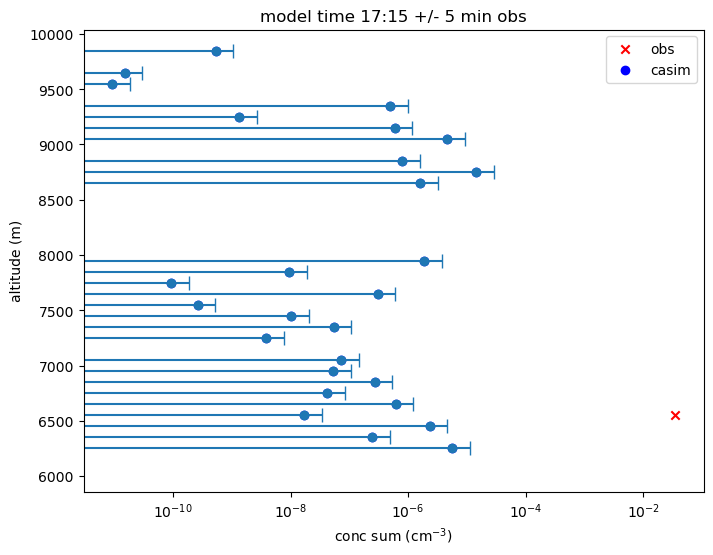

In [31]:
full_time_str = str(model_time)
time_str = full_time_str[11:16]

#alt_slice = corresponding_time_df[(corresponding_time_df['alt'] >= 6500) & (corresponding_time_df['alt'] < 6600)]

plt.figure(figsize=(8,6))
plt.scatter(obs_height_variation['obs_conc'], obs_height_variation['height'], color = 'red', marker = 'x', label = 'obs')
plt.scatter(model_height_variation['mean_conc'], model_height_variation['height'], color = 'blue', label = 'casim')
# model variation
#plt.fill_between(model_height_variation['mean_conc'], model_height_variation['height'] - model_height_variation['std_conc'], model_height_variation['height'] + model_height_variation['std_conc'], alpha=0.3, label='±1 SD') # looks insane
plt.errorbar(
    model_height_variation['mean_conc'],
    model_height_variation['height'],
    xerr=model_height_variation['mean_conc'],
    fmt='o',
    capsize=5,
    linestyle='none')

plt.xscale('log')
plt.xlabel('conc sum (cm$^{-3}$)')
plt.ylabel('altitude (m)')
plt.title(f'model time {time_str} +/- 5 min obs')
plt.legend()

## basically sum of the average particles (within size range) seen in this time step

#### another approach for dealing with model - obs comparison
the plot through height was not great

(array([8., 1., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([1.28187552e-05, 5.95655523e-04, 1.17849229e-03, 1.76132906e-03,
        2.34416583e-03, 2.92700260e-03, 3.50983936e-03, 4.09267613e-03,
        4.67551290e-03, 5.25834967e-03, 5.84118644e-03, 6.42402321e-03,
        7.00685997e-03, 7.58969674e-03, 8.17253351e-03, 8.75537028e-03,
        9.33820705e-03, 9.92104382e-03, 1.05038806e-02, 1.10867174e-02,
        1.16695541e-02, 1.22523909e-02, 1.28352277e-02, 1.34180644e-02,
        1.40009012e-02, 1.45837380e-02, 1.51665747e-02, 1.57494115e-02,
        1.63322483e-02, 1.69150850e-02, 1.74979218e-02]),
 <BarContainer object of 30 artists>)

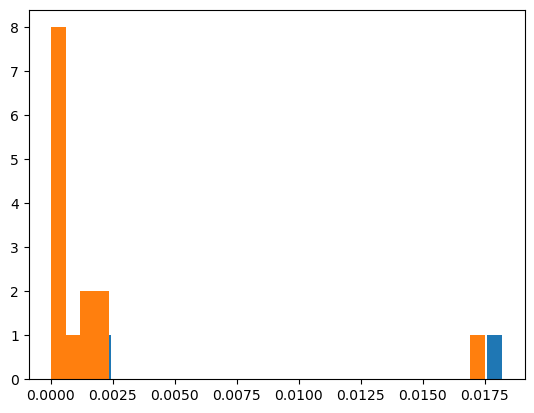

In [73]:
none_0_ch0 = four_passes_df['ch0_mean_conc'][four_passes_df['ch0_mean_conc'] != 0]
none_0_ch1 = four_passes_df['ch1_mean_conc'][four_passes_df['ch1_mean_conc'] != 0]


#plt.hist(four_passes_df['ch0_mean_conc'], bins=30, density=True)  
#plt.hist(four_passes_df['ch1_mean_conc'], bins=30, density=True)
plt.hist(none_0_ch0, bins=30)#, normed=True) 
plt.hist(none_0_ch1, bins=30)#, normed=True) 



In [55]:

graupel_n = masked_both_dict_17['hydro']['number_of_graupel_particles_per_kg_of_air'] # kg-1
graupel_m = masked_both_dict_17['hydro']['mass_fraction_of_graupel_in_air'] # kg-1
#convert to m-3
air_density = masked_both_dict_17['density']['Density used for rad layers (kg m-3)']
graupel_m_m3 = graupel_m * air_density
graupel_n_m3 = graupel_n * air_density

## also need same for model plot
hydro='graupel'
mu = hydroparameters[hydro][0]
lam = calc_lambda(graupel_m_m3, graupel_n_m3 ,hydro) # ! nice ! i think it has broadcasted across 3d space!

min_2ds_size = 300e-6
max_2ds_size = 1280e-6
total_conc_avg = (partial_integral_gamma(graupel_n_m3,mu,lam, min_2ds_size, max_2ds_size)/1e6)


'''

## okay we create set of bins to group levels into 

height_bins = np.arange(6000, 10000, 100)
#print(height_bins[0])
#print(height_bins[1])



# need to make a mask for each height interested in 
final_slice_average = []
for i in range(len(height_bins) -1):
    bin0 = height_bins[i]
    bin1 = height_bins[i+1]
    height = (bin0 + bin1)/2
    asl_mask = (altASL  >= bin0) & (altASL  < bin1)
    height_g_n = graupel_n.where(asl_mask)
    height_g_m = graupel_m.where(asl_mask)
    
    # in m3 please 
    height_g_n_m3 =  height_g_n * air_density
    height_g_m_m3 =  height_g_m * air_density
    

    # then can do lambda calc for this level + find its average etc etc
    height_lam = calc_lambda(height_g_m_m3, height_g_n_m3 ,hydro) # ! nice ! i think it has broadcasted across 3d space!

    lam_mean_height = height_lam.mean(skipna=True) # no clue of shape, so just whatever is at that level
    mean_g_n_m3_height = height_g_n_m3.mean(skipna=True)
    std_g_n_m3_height = height_g_n_m3.std(skipna=True)
    

    # then we do total calc of particles # !! based on the average values
    total_conc_avg = (partial_integral_gamma(mean_g_n_m3_height,mu,lam_mean_height, min_2ds_size, max_2ds_size)/1e6)
    
    slice_avg = {'height' : height, 'mean_lam':  lam_mean_height.item(), 'mean_conc':total_conc_avg.item(), 'std_conc':std_g_n_m3_height.item()}
    final_slice_average.append(slice_avg)

model_height_variation = pd.DataFrame(final_slice_average)

'''
    

"\n\n## okay we create set of bins to group levels into \n\nheight_bins = np.arange(6000, 10000, 100)\n#print(height_bins[0])\n#print(height_bins[1])\n\n\n\n# need to make a mask for each height interested in \nfinal_slice_average = []\nfor i in range(len(height_bins) -1):\n    bin0 = height_bins[i]\n    bin1 = height_bins[i+1]\n    height = (bin0 + bin1)/2\n    asl_mask = (altASL  >= bin0) & (altASL  < bin1)\n    height_g_n = graupel_n.where(asl_mask)\n    height_g_m = graupel_m.where(asl_mask)\n\n    # in m3 please \n    height_g_n_m3 =  height_g_n * air_density\n    height_g_m_m3 =  height_g_m * air_density\n\n\n    # then can do lambda calc for this level + find its average etc etc\n    height_lam = calc_lambda(height_g_m_m3, height_g_n_m3 ,hydro) # ! nice ! i think it has broadcasted across 3d space!\n\n    lam_mean_height = height_lam.mean(skipna=True) #\xa0no clue of shape, so just whatever is at that level\n    mean_g_n_m3_height = height_g_n_m3.mean(skipna=True)\n    std_g_n_m

(array([7.04246045e+03, 1.10677547e+02, 4.57146391e+01, 1.20301682e+01,
        0.00000000e+00, 2.40603364e+00, 2.40603364e+00, 2.40603364e+00,
        4.81206727e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.81206727e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.40603364e+00, 0.00000000e+00, 0.00000000e+00,
        2.40603364e+00, 4.81206727e+00]),
 array([2.85005074e-23, 1.38172137e-04, 2.76344274e-04, 4.14516410e-04,
        5.52688547e-04, 6.90860684e-04, 8.29032821e-04, 9.67204957e-04,
        1.10537709e-03, 1.24354923e-03, 1.38172137e-03, 1.51989350e-03,
        1.65806564e-03, 1.79623778e-03, 1.93440991e-03, 2.07258205e-03,
        2.21075419e-03, 2.34892632e-03, 2.48709846e-03, 2.62527060e-03,
        2.76344274e-03, 2.90161487e-03, 3.03978701e-03, 3.17795915e-03,
        3.31613128e-03

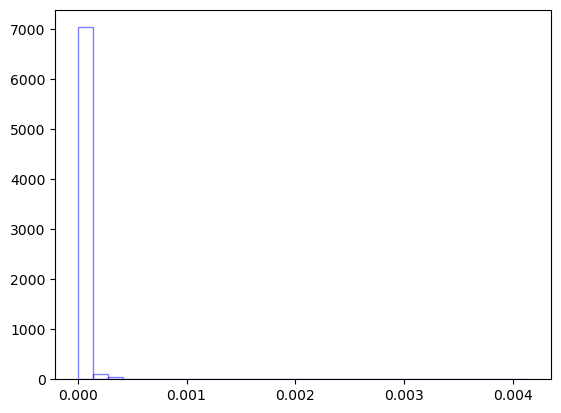

In [ ]:
# remove dimensions
flat_conc  = total_conc_avg.stack(all_dims=("model_level_number", "grid_latitude", "grid_longitude"))
# remove 0 values
flat_none_0 = flat_conc[flat_conc != 0]


Text(0.5, 0, 'conc $cm^{-3}$')

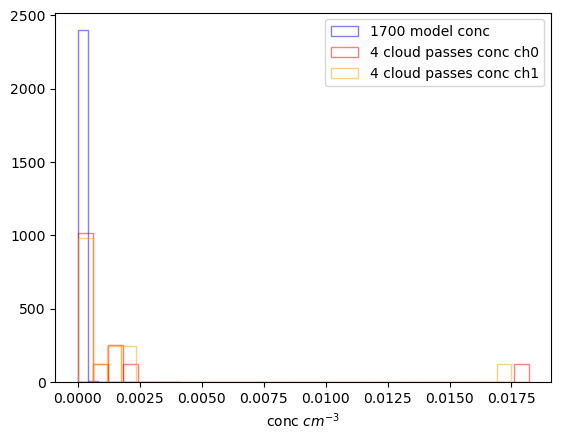

In [ ]:
plt.hist(flat_none_0, bins=10, edgecolor= 'blue', facecolor = 'none', alpha=0.5, label = '1700 model conc', density = True)#, stacked = True) #, normed=True)   # normalized
plt.hist(none_0_ch0, bins=30, edgecolor= 'red', facecolor = 'none', alpha=0.5, label = '4 cloud passes conc ch0', density = True)#, stacked = True) #, normed=True)   # normalized 
plt.hist(none_0_ch1, bins=30, edgecolor= 'orange', facecolor = 'none', alpha=0.5, label = '4 cloud passes conc ch1', density = True)#, stacked = True) #, normed=True)   # normalized
plt.legend()
plt.xlabel('conc $cm^{-3}$')

#plt.savefig('first_conc_histogram.pdf')

## writing into colab - extra code

In [61]:
## subset csv files -> specific pass time
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from glob import glob
import seaborn as sns
import xesmf as xe
import pandas as pd
import json

from scipy.special import gamma
from scipy.special import gammainc, gammaincc, gdtr

import sys
# actually, pull in functions i have written previously
sys.path.append('/home/users/esree/phd_plots/paper1_figs/')
from shared_functions import pull_files_together, cloud_pass_time, cnn_labelled_df

import os

In [2]:

ds_path = '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/v3_conc/' # different paths, as accounted for HPC in v3 - only 2ds
hvps_path = '/gws/nopw/j04/dcmex/users/ezriab/processed_stats/v2_conc/' 
manc_file_loc = '/home/users/esree/dcmex_instruments/co-located-files/manc_ice_files.json' # 2ds + hvps paired for a date (also has faam too - for TAS adjustment)

full_data_dict = pull_files_together(ds_path, hvps_path, manc_file_loc)
day_dict = full_data_dict['220730'] # this is the date we are comparing to


In [3]:
import json

ch0_df, ch1_df, hvps_df = cnn_labelled_df(day_dict)
start_time, end_time = cloud_pass_time(day_dict) # fabulous function made earlier, get pass start / end times

pass_time_dict = {}
for i in range(len(start_time)):
    pass_time_dict[str(i)] = {}
    pass_time_dict[str(i)]['start'] = start_time[i].isoformat()
    pass_time_dict[str(i)]['end'] = end_time[i].isoformat()
    print(f'{i}: s: {start_time[i]}, e: {end_time[i]}')


with open("30th_pass_times.json", "w") as f:
    json.dump(pass_time_dict, f, indent=2)


# now need to make corresponding column, with pass time associated with each row


/home/users/esree/phd_plots/paper1_figs/shared_functions.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['second'] = pd.to_datetime(df['second'])
/home/users/esree/phd_plots/paper1_figs/shared_functions.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['second'] = pd.to_datetime(df['second'])
/home/users/esree/phd_plots/paper1_figs/shared_functions.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

0: s: 2022-07-30 15:24:33, e: 2022-07-30 15:24:37
1: s: 2022-07-30 16:38:50, e: 2022-07-30 16:40:00
2: s: 2022-07-30 16:44:20, e: 2022-07-30 16:45:09
3: s: 2022-07-30 16:50:54, e: 2022-07-30 16:51:13
4: s: 2022-07-30 16:55:31, e: 2022-07-30 16:56:07
5: s: 2022-07-30 16:59:48, e: 2022-07-30 17:00:33
6: s: 2022-07-30 17:04:23, e: 2022-07-30 17:05:41
7: s: 2022-07-30 17:09:21, e: 2022-07-30 17:10:24
8: s: 2022-07-30 17:15:05, e: 2022-07-30 17:15:32
9: s: 2022-07-30 17:56:39, e: 2022-07-30 17:56:43
10: s: 2022-07-30 18:22:54, e: 2022-07-30 18:22:58
11: s: 2022-07-30 18:44:08, e: 2022-07-30 18:45:54
12: s: 2022-07-30 18:51:06, e: 2022-07-30 18:51:24
13: s: 2022-07-30 18:55:32, e: 2022-07-30 18:56:35
14: s: 2022-07-30 19:01:27, e: 2022-07-30 19:02:05
15: s: 2022-07-30 19:05:17, e: 2022-07-30 19:06:31
16: s: 2022-07-30 19:11:14, e: 2022-07-30 19:12:02
17: s: 2022-07-30 19:15:35, e: 2022-07-30 19:16:16
18: s: 2022-07-30 19:20:52, e: 2022-07-30 19:21:54
19: s: 2022-07-30 19:51:55, e: 2022-07-30

In [8]:
## assign a pass time - and also record start / end pass times in json file - no need for nev
new_ch0 = ch0_df.copy()
new_ch0['pass_n'] = np.nan

for i in range(len(start_time)):
    start_t = start_time[i]
    end_t = end_time[i]
    sub_df = new_ch0[(new_ch0['second'] >= start_t) & ((new_ch0['second'] <= end_t))]
    idx_list = sub_df.index.values
    new_ch0.loc[idx_list, 'pass_n'] = str(i) # update to correspond to pass number


/tmp/ipykernel_473468/2575986926.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  new_ch0.loc[idx_list, 'pass_n'] = str(i) # update to correspond to pass number


In [27]:
min_gridlat = -0.15
max_gridlat = 0.14

min_gridlon = 359.93
max_gridlon = 360.11

In [28]:
def open_correct_hr_files(hr_list):
    file_ending = ['.nc', '_density.nc', '_w.nc']
    file_names = ['hydro', 'density', 'updraft'] # number = hydrometeor values // density
    ## these locations will have to change
    nc_file_loc = '/gws/nopw/j04/dcmex/users/dfinney/data/CASIM/dd455_4apr2024_ncs_27feb2025v2/20220730T0000Z/expt1/'
    orog_loc = '/gws/nopw/j04/dcmex/users/dfinney/data/CASIM/dd455_4apr2024_ncs_27feb2025v2/20220716T0000Z_LMagda_km1p5set1_expt1_pa000_model_orog.nc'
    ###########################

    # first file, build re-gridder -> so w is on same grid straight away + can be used for all files
    ### likewise file names?
    hydro_file = xr.load_dataset(f'{nc_file_loc}20220730T0000Z_LMagda_km1p5set1_expt1_pz0{hr_list[0]}{file_ending[0]}',  decode_timedelta=True)
    updraft_file = xr.load_dataset(f'{nc_file_loc}20220730T0000Z_LMagda_km1p5set1_expt1_pz0{hr_list[0]}{file_ending[2]}',  decode_timedelta=True)
    regridder = xe.Regridder(updraft_file, hydro_file, "bilinear") ## computationally expensive, so do it once

    ## making altASL
    orography = xr.load_dataset(orog_loc, decode_timedelta=True) ## orography over
    orography_regrid = regridder(orography)
    altASL = hydro_file['level_height'] + hydro_file['sigma'] *  orography_regrid['surface_altitude']
    altASL_notime = altASL.drop_vars("time") # silly time

    final_files_dict = {}
    for j in range(len(hr_list)):
        hr_dict = {}
        for i in range(len(file_ending)):
            file = f'{nc_file_loc}20220730T0000Z_LMagda_km1p5set1_expt1_pz0{hr_list[j]}{file_ending[i]}'
            xr_ds = xr.load_dataset(file, decode_timedelta=True)
            if i == 2:
                xr_ds = regridder(xr_ds) # fix updraft
            hr_dict[file_names[i]] = xr_ds

        ## as density + updraft are on slightly different times, we will use hydro as a base, changing them to it
        hydro = hr_dict['hydro']
        density = hr_dict['density']
        updraft = hr_dict['updraft']

        density = density.assign_coords(time=hydro.time)
        updraft = updraft.assign_coords(time=hydro.time)

        combined = xr.merge([hydro, density, updraft])
        combined = combined.assign_coords(true_level_height_asl=altASL_notime) # adding in altASL as coordinate

        final_files_dict[str(hr_list[j])] = combined

    return final_files_dict

## this is applying to grid_lat and grid_lon - which is different from actual lat + lon
def slice_smaller_domain(dataframe, min_lat, max_lat, min_lon, max_lon):
    sliced_df = dataframe.sel(grid_latitude=slice(min_lat, max_lat), grid_longitude=slice(min_lon, max_lon))
    return sliced_df


In [63]:
#glob(f'{nc_file_loc}20220731T0000Z_LMagda_km1p5set1_expt1_pz01*.nc')
print("Directory exists:", os.path.exists(nc_file_loc))
print("Contents:", os.listdir(nc_file_loc))


Directory exists: True
Contents: ['20220730T0000Z_LMagda_km1p5set1_expt1_pa000.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pa000_u10m.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pa000_v10m.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pw012.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pw013.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pw014.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pw015.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pw016.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pw017.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pw018.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pw019.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pw020.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pw021.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pw022.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pw023.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pw024.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pw025.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pw026.nc', '20220730T0000Z_LMagda_km1p5set1_expt1_pw027.nc', '20220

In [65]:
nc_file_loc = '/gws/nopw/j04/dcmex/users/dfinney/data/CASIM/dd455_4apr2024_ncs_27feb2025v2/20220730T0000Z/expt1/'
orog_loc = '/gws/nopw/j04/dcmex/users/dfinney/data/CASIM/dd455_4apr2024_ncs_27feb2025v2/20220716T0000Z_LMagda_km1p5set1_expt1_pa000_model_orog.nc'
   


''' this will not be needed in colab '''
hydro_file = xr.load_dataset(f'{nc_file_loc}20220730T0000Z_LMagda_km1p5set1_expt1_pz016.nc',  decode_timedelta=True)
updraft_file = xr.load_dataset(f'{nc_file_loc}20220730T0000Z_LMagda_km1p5set1_expt1_pz016_w.nc',  decode_timedelta=True)
regridder = xe.Regridder(updraft_file, hydro_file, "bilinear") ## computationally expensive, so do it once
''' - - - - - - - - - - - - - - - - - - - - - '''
## making altASL
orography = xr.load_dataset(orog_loc, decode_timedelta=True) ## orography over
orography_regrid = regridder(orography)
altASL = hydro_file['level_height'] + hydro_file['sigma'] *  orography_regrid['surface_altitude']
altASL_notime = altASL.drop_vars("time") # silly time


ValueError: Every dimension requires a corresponding 1D coordinate and index for inferring concatenation order but the coordinate 'time' has no corresponding index

In [27]:
### need to update 
nc_file_loc = '/gws/nopw/j04/dcmex/users/dfinney/data/CASIM/dd455_4apr2024_ncs_27feb2025v2/20220730T0000Z/expt1/'
new_nc_save_loc = './new_nc/'
a_time = '21'
density_name = f'20220730T0000Z_LMagda_km1p5set1_expt1_pz0{a_time}_density.nc'

a_hydro = xr.open_dataset(f'{nc_file_loc}20220730T0000Z_LMagda_km1p5set1_expt1_pz0{a_time}.nc', decode_timedelta=True) # grab all hrs of data
a_density = xr.open_dataset(f'{nc_file_loc}20220730T0000Z_LMagda_km1p5set1_expt1_pz0{a_time}_density.nc', decode_timedelta=True) # grab all hrs of data
new_density = a_density.assign_coords(time=a_hydro.time)
new_density

<xarray.Dataset> Size: 27MB
Dimensions:                               (model_level_number: 70,
                                           grid_latitude: 300,
                                           grid_longitude: 300)
Coordinates:
  * model_level_number                    (model_level_number) int32 280B 1 ....
  * grid_latitude                         (grid_latitude) float32 1kB -2.025 ...
  * grid_longitude                        (grid_longitude) float64 2kB 358.0 ...
    forecast_period                       timedelta64[ns] 8B ...
    forecast_reference_time               datetime64[ns] 8B ...
    time                                  datetime64[ns] 8B ...
    level_height                          (model_level_number) float32 280B ...
    sigma                                 (model_level_number) float32 280B ...
    lon                                   (grid_latitude, grid_longitude) float64 720kB ...
    lat                                   (grid_latitude, grid_longitude) float64 720kB ...
Data variables:
    Density used for rad layers (kg m-3)  (model_level_number, grid_latitude, grid_longitude) float32 25MB ...
Attributes: (12/14)
    um_suite:          u-dd455@281404
    casim_branches:    https://code.metoffice.gov.uk/trac/monc/browser/casim/...
    um_branches:       https://code.metoffice.gov.uk/trac/um/browser/main/bra...
    creator_contact:   Declan Finney (d.l.finney@leeds.ac.uk), University of ...
    title:             Simulations over the southwest USA for the DCMEX campa...
    institution:       Generated on UK Met Office Monsoon computing facility,...
    ...                ...
    coord_system:      RotatedGeogCS(56.0, 72.80000305175781, ellipsoid=GeogC...
    conventions:       CF-1.7
    expt_name:         ctl
    NCO:               netCDF Operators version 5.2.7 (Homepage = http://nco....
    history:           Fri Feb 28 14:49:40 2025: ncatted -O -a expt_descripti...
    expt_description:  Control experiment using 250E6 kg-1 fixed droplet numb...

In [28]:
a_hydro

<xarray.Dataset> Size: 405MB
Dimensions:                                           (model_level_number: 70,
                                                       grid_latitude: 300,
                                                       grid_longitude: 300)
Coordinates:
  * model_level_number                                (model_level_number) int32 280B ...
  * grid_latitude                                     (grid_latitude) float32 1kB ...
  * grid_longitude                                    (grid_longitude) float64 2kB ...
    forecast_period                                   timedelta64[ns] 8B ...
    forecast_reference_time                           datetime64[ns] 8B ...
    time                                              datetime64[ns] 8B ...
    level_height                                      (model_level_number) float32 280B ...
    sigma                                             (model_level_number) float32 280B ...
    lon                                               (grid_latitude, grid_longitude) float64 720kB ...
    lat                                               (grid_latitude, grid_longitude) float64 720kB ...
Data variables: (12/16)
    number_of_cloud_droplets_per_kg_of_air            (model_level_number, grid_latitude, grid_longitude) float32 25MB ...
    number_of_rain_drops_per_kg_of_air                (model_level_number, grid_latitude, grid_longitude) float32 25MB ...
    number_of_ice_particles_per_kg_of_air             (model_level_number, grid_latitude, grid_longitude) float32 25MB ...
    number_of_snow_aggregates_per_kg_of_air           (model_level_number, grid_latitude, grid_longitude) float32 25MB ...
    number_of_graupel_particles_per_kg_of_air         (model_level_number, grid_latitude, grid_longitude) float32 25MB ...
    cloud_volume_fraction_in_atmosphere_layer         (model_level_number, grid_latitude, grid_longitude) float32 25MB ...
    ...                                                ...
    air_temperature                                   (model_level_number, grid_latitude, grid_longitude) float32 25MB ...
    mass_fraction_of_cloud_ice_in_air                 (model_level_number, grid_latitude, grid_longitude) float32 25MB ...
    mass_fraction_of_cloud_liquid_water_in_air        (model_level_number, grid_latitude, grid_longitude) float32 25MB ...
    mass_fraction_of_graupel_in_air                   (model_level_number, grid_latitude, grid_longitude) float32 25MB ...
    mass_fraction_of_rain_in_air                      (model_level_number, grid_latitude, grid_longitude) float32 25MB ...
    specific_humidity                                 (model_level_number, grid_latitude, grid_longitude) float32 25MB ...
Attributes: (12/14)
    um_suite:          u-dd455@281404
    casim_branches:    https://code.metoffice.gov.uk/trac/monc/browser/casim/...
    um_branches:       https://code.metoffice.gov.uk/trac/um/browser/main/bra...
    creator_contact:   Declan Finney (d.l.finney@leeds.ac.uk), University of ...
    title:             Simulations over the southwest USA for the DCMEX campa...
    institution:       Generated on UK Met Office Monsoon computing facility,...
    ...                ...
    coord_system:      RotatedGeogCS(56.0, 72.80000305175781, ellipsoid=GeogC...
    conventions:       CF-1.7
    expt_name:         ctl
    NCO:               netCDF Operators version 5.2.7 (Homepage = http://nco....
    history:           Fri Feb 28 14:49:41 2025: ncatted -O -a expt_descripti...
    expt_description:  Control experiment using 250E6 kg-1 fixed droplet numb...

In [29]:
#new_density.to_netcdf(new_nc_save_loc+density_name)

In [7]:
new_density = a_density.assign_coords(time=a_hydro.time)
new_density

<xarray.Dataset> Size: 102MB
Dimensions:                               (time: 4, model_level_number: 70,
                                           grid_latitude: 300,
                                           grid_longitude: 300)
Coordinates:
  * model_level_number                    (model_level_number) int32 280B 1 ....
  * grid_latitude                         (grid_latitude) float32 1kB -2.025 ...
  * grid_longitude                        (grid_longitude) float64 2kB 358.0 ...
    forecast_reference_time               datetime64[ns] 8B ...
    forecast_period                       (time) timedelta64[ns] 32B dask.array<chunksize=(4,), meta=np.ndarray>
    level_height                          (model_level_number) float32 280B dask.array<chunksize=(70,), meta=np.ndarray>
    sigma                                 (model_level_number) float32 280B dask.array<chunksize=(70,), meta=np.ndarray>
    lon                                   (grid_latitude, grid_longitude) float64 720kB dask.array<chunksize=(300, 300), meta=np.ndarray>
    lat                                   (grid_latitude, grid_longitude) float64 720kB dask.array<chunksize=(300, 300), meta=np.ndarray>
  * time                                  (time) datetime64[ns] 32B 2022-07-3...
Data variables:
    Density used for rad layers (kg m-3)  (time, model_level_number, grid_latitude, grid_longitude) float32 101MB dask.array<chunksize=(2, 35, 150, 150), meta=np.ndarray>
Attributes: (12/14)
    um_suite:          u-dd455@281404
    casim_branches:    https://code.metoffice.gov.uk/trac/monc/browser/casim/...
    um_branches:       https://code.metoffice.gov.uk/trac/um/browser/main/bra...
    creator_contact:   Declan Finney (d.l.finney@leeds.ac.uk), University of ...
    title:             Simulations over the southwest USA for the DCMEX campa...
    institution:       Generated on UK Met Office Monsoon computing facility,...
    ...                ...
    coord_system:      RotatedGeogCS(56.0, 72.80000305175781, ellipsoid=GeogC...
    conventions:       CF-1.7
    expt_name:         ctl
    NCO:               netCDF Operators version 5.2.7 (Homepage = http://nco....
    history:           Fri Feb 28 14:49:05 2025: ncatted -O -a expt_descripti...
    expt_description:  Control experiment using 250E6 kg-1 fixed droplet numb...

In [67]:
all_hydro = xr.open_mfdataset(f'{nc_file_loc}20220730T0000Z_LMagda_km1p5set1_expt1_pz01*.nc', decode_timedelta=True) # grab all hrs of data
all_density = xr.open_mfdataset(f'{nc_file_loc}20220731T0000Z_LMagda_km1p5set1_expt1_pz01*_density.nc', decode_timedelta=True) # grab all hrs of data
# need to align, so time is the same - so can combine into 1 xr
all_density = density.assign_coords(time=all_hydro.time)
combined = xr.merge([all_hydro, all_density, updraft])
# also assign altASL as defined previously

combined = combined.assign_coords(true_level_height_asl=altASL_notime) # adding in altASL as coordinate


MergeError: conflicting values for variable 'forecast_reference_time' on objects to be combined. You can skip this check by specifying compat='override'.

In [68]:
all_hydro

NameError: name 'all_hydro' is not defined

In [29]:
#time_list = ['16', '17', '18'] #['16', '17', '18', '19', '20', '21']
#subset_files = open_correct_hr_files(time_list) # this takes a while


## now can slize to size we want
min_gridlat = -0.15
max_gridlat = 0.14

min_gridlon = 359.93
max_gridlon = 360.11
sliced_df = dataframe.sel(grid_latitude=slice(min_gridlat, max_gridlat), grid_longitude=slice(min_gridlon, max_gridlon))


In [30]:
#subset_files['16']
 
sliced_files = {key: slice_smaller_domain(data, min_gridlat, max_gridlat, min_gridlon, max_gridlon) for key, data in subset_files.items()}

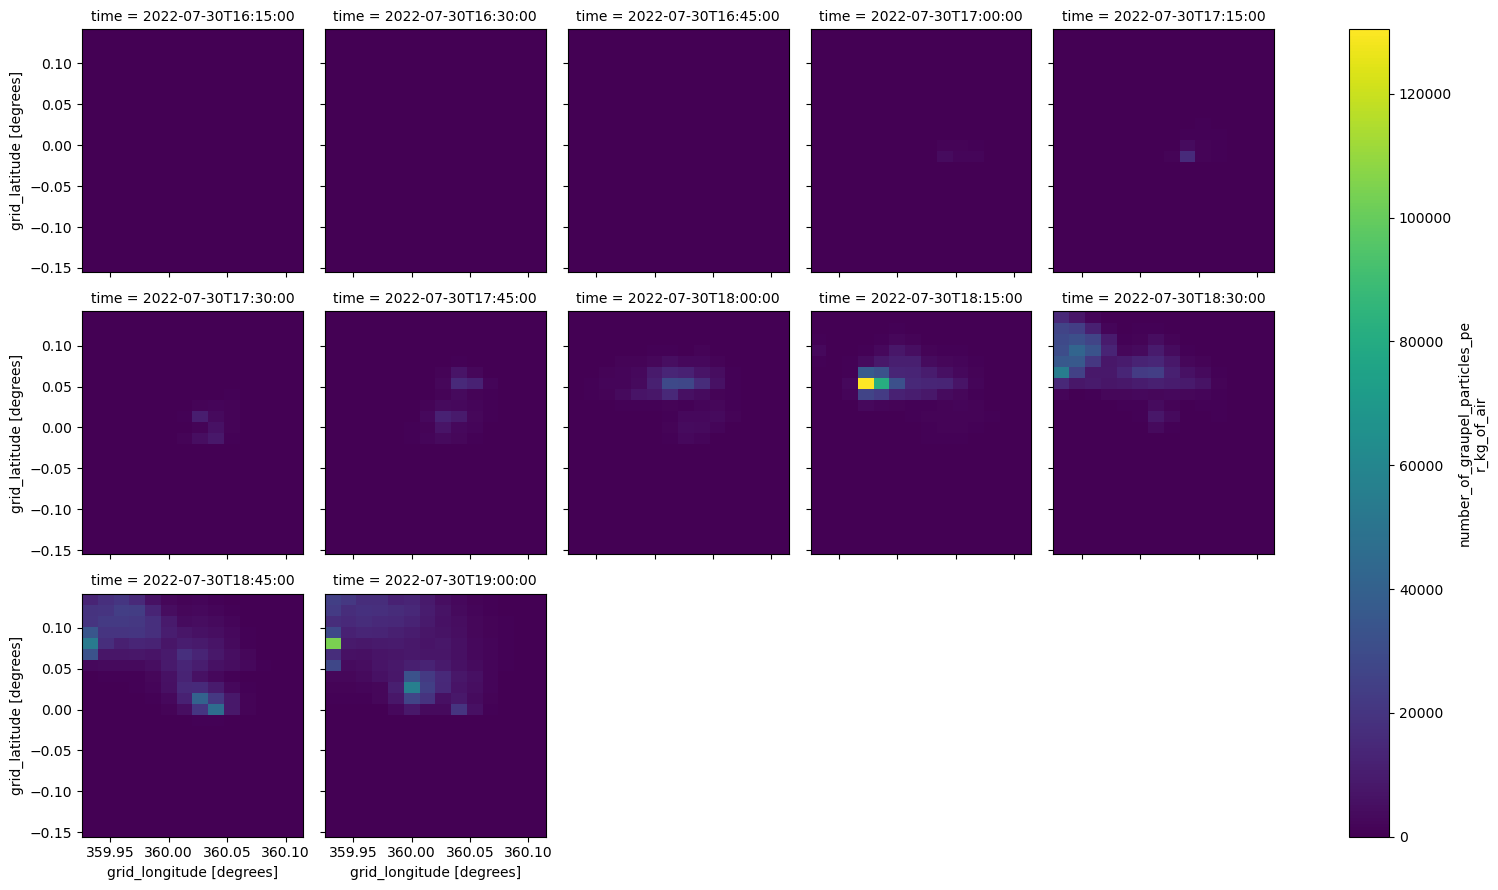

In [31]:
# also combine the different hrs together:
df_list= [data for key, data in sliced_files.items()]
big_df = xr.merge(df_list)
#max_graupel_values = big_df['number_of_graupel_particles_per_kg_of_air']
#level_heights_masked_limited.max(["model_level_number"]).plot(col="time", col_wrap=5)
big_df['number_of_graupel_particles_per_kg_of_air'].max(["model_level_number"]).plot(col="time", col_wrap=5)


In [23]:
### functions to calculate distribution
## given constants from Field, et al. (2023)
## mu, mass-dimention (a,b)
hydroparameters = {'liquid':[2.5,522,3],
                   'rain':[2.5,522,3],
                   'ice':[2.5,np.pi*200/6,3],
                   'snow':[2,0.026,2],
                   'graupel':[2.5,np.pi*500/6,3]}

## Function for calculating lamda from mass and number
## with prescribed model number + mass (+ specify type of hydrometeor), lambda can be calculated - to work out distribution
def calc_lambda(model_mass, model_num, hydro):
    # Read in gamma PDF values (Field et al., 2023, Table 1)
    mu = hydroparameters[hydro][0]
    c = hydroparameters[hydro][1]
    d = hydroparameters[hydro][2]
    
    gamma_ratio = gamma(1+mu+d) / gamma(1+mu)
    nm_ratio = model_num / model_mass
    if d == 2:
        lam = np.sqrt(c*nm_ratio*gamma_ratio)
    elif d == 3:
        lam = np.cbrt(c*nm_ratio*gamma_ratio)
    else:
        lam = np.nan
    return lam

### Function for model gamma function in (m-3 m-1)
# x = diameter, n = number conc, mu = mu, lambda = lambda (needs calculating)
'''
def model_gamma_pdf(x,n,mu,lamda):
    n0 = (n) * (lamda**(1+mu)) / (gamma(1+mu)) # directly pulled from field paper - (A2)
    N = n0 * (x**mu) * (np.exp(-lamda*x)) 
    return N
'''

### Function for integral over the lower and upper limits of the gamma PDF
def partial_integral_gamma(n,mu,lam,lower,upper):
    lower_inc = gammainc(1+mu,lam*lower)
    upper_inc = gammainc(1+mu,lam*upper)
    return n*(upper_inc-lower_inc)

In [33]:
# pulling out the graupel values from the nc files + calculate lambda + conc for given sizes
def graupel_calc(big_dict, hydro, min_size, max_size):

    ### other functions needed within this to do calculations ### ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    ## Function for calculating lamda from mass and number
    ## with prescribed model number + mass (+ specify type of hydrometeor), lambda can be calculated - to work out distribution
    def calc_lambda(model_mass, model_num, hydro):
        # Read in gamma PDF values (Field et al., 2023, Table 1)
        mu = hydroparameters[hydro][0]
        c = hydroparameters[hydro][1]
        d = hydroparameters[hydro][2]
        
        gamma_ratio = gamma(1+mu+d) / gamma(1+mu)
        nm_ratio = model_num / model_mass
        if d == 2:
            lam = np.sqrt(c*nm_ratio*gamma_ratio)
        elif d == 3:
            lam = np.cbrt(c*nm_ratio*gamma_ratio)
        else:
            lam = np.nan
        return lam

    ### Function for integral over the lower and upper limits of the gamma PDF
    def partial_integral_gamma(n,mu,lam,lower,upper):
        lower_inc = gammainc(1+mu,lam*lower)
        upper_inc = gammainc(1+mu,lam*upper)
        return n*(upper_inc-lower_inc)
    ### ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    
    new_graupel_dict = {}
    mu = hydroparameters[hydro][0]

    for key in big_dict:
        graupel_n = big_dict[key]['number_of_graupel_particles_per_kg_of_air'] # kg-1
        graupel_m = big_dict[key]['mass_fraction_of_graupel_in_air'] # kg kg-1
    
        # not most useful of units, so will convert to m3
        air_density = big_dict[key]['Density used for rad layers (kg m-3)'] # kg m-3 
        ## !!!! basic nc -> number = kg-1 units, use air density (kg m-3) -> kg-1 * kg m-3 = m-3 units
        ## !!!! basic nc -> mass = kg kg-1 units, use air density (kg m-3) -> kg kg-1 * kg m-3 = kg m-3 units
    
        graupel_m_m3 = graupel_m * air_density
        graupel_n_m3 = graupel_n * air_density

        # calculation of lambda, naughty, in another function
        g_lambda = calc_lambda(graupel_m_m3, graupel_n_m3, hydro)

        # calculate total graupel conc, for given size range
        total_conc = partial_integral_gamma(graupel_n_m3, mu, g_lambda, min_size, max_size)

        new_graupel_dict[key] = {'g_mass' : graupel_m_m3, 'g_number' : graupel_n_m3, 'lambda' : g_lambda, 'conc': total_conc}
        
    return new_graupel_dict


In [50]:
# pulling out the graupel values from the nc files + calculate lambda + conc for given sizes
# also going to assign these new values as variables
def graupel_calc(big_dict, hydro, min_size, max_size):

    ### other functions needed within this to do calculations ### ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    ## Function for calculating lamda from mass and number
    ## with prescribed model number + mass (+ specify type of hydrometeor), lambda can be calculated - to work out distribution
    def calc_lambda(model_mass, model_num, hydro):
        # Read in gamma PDF values (Field et al., 2023, Table 1)
        mu = hydroparameters[hydro][0]
        c = hydroparameters[hydro][1]
        d = hydroparameters[hydro][2]
        
        gamma_ratio = gamma(1+mu+d) / gamma(1+mu)
        nm_ratio = model_num / model_mass
        if d == 2:
            lam = np.sqrt(c*nm_ratio*gamma_ratio)
        elif d == 3:
            lam = np.cbrt(c*nm_ratio*gamma_ratio)
        else:
            lam = np.nan
        return lam

    ### Function for integral over the lower and upper limits of the gamma PDF
    def partial_integral_gamma(n,mu,lam,lower,upper):
        lower_inc = gammainc(1+mu,lam*lower)
        upper_inc = gammainc(1+mu,lam*upper)
        return n*(upper_inc-lower_inc)
    ### ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 

    mu = hydroparameters[hydro][0]

    new_big_dict = {}

    for key in big_dict:
        ds = big_dict[key]  # original xarray Dataset

        graupel_n = ds['number_of_graupel_particles_per_kg_of_air']  # kg^-1
        graupel_m = ds['mass_fraction_of_graupel_in_air']           # kg kg^-1
        air_density = ds['Density used for rad layers (kg m-3)']     # kg m^-3

        # Convert to per-volume units
        graupel_m_m3 = graupel_m * air_density
        graupel_n_m3 = graupel_n * air_density

        # Calculate lambda
        g_lambda = calc_lambda(graupel_m_m3, graupel_n_m3, hydro)

        # Total graupel concentration in the size range
        total_conc = partial_integral_gamma(graupel_n_m3, mu, g_lambda, min_size, max_size)

        # Add new variables to the existing dataset
        ds = ds.assign(
            graupel_mass_m3 = (ds.dims, graupel_m_m3.data),
            graupel_number_m3 = (ds.dims, graupel_n_m3.data),
            graupel_lambda = (ds.dims, g_lambda.data),
            graupel_total_conc = (ds.dims, total_conc.data)
        )

        # Keep all original variables
        new_big_dict[key] = ds

    return new_big_dict

In [51]:
## given constants from Field, et al. (2023)
## mu, mass-dimention (a,b)
hydroparameters = {'liquid':[2.5,522,3],
                   'rain':[2.5,522,3],
                   'ice':[2.5,np.pi*200/6,3],
                   'snow':[2,0.026,2],
                   'graupel':[2.5,np.pi*500/6,3]}
# size limits for 2ds - so compare like for like
min_2ds_size = 300e-6 # in m - but = 300 micron
max_2ds_size = 1280e-6 # 1280 micron

hydro='graupel'
graupel_data = graupel_calc(sliced_files, hydro, min_2ds_size, max_2ds_size) # this is pulling out mass, number and calculating lambda + total concentration


In [52]:
graupel_data['16']

<xarray.Dataset> Size: 8MB
Dimensions:                                           (time: 4,
                                                       model_level_number: 70,
                                                       grid_latitude: 22,
                                                       grid_longitude: 14)
Coordinates:
  * time                                              (time) datetime64[ns] 32B ...
  * model_level_number                                (model_level_number) int32 280B ...
  * grid_latitude                                     (grid_latitude) float32 88B ...
  * grid_longitude                                    (grid_longitude) float64 112B ...
    forecast_reference_time                           datetime64[ns] 8B 2022-...
    forecast_period                                   timedelta64[ns] 8B 00:0...
    level_height                                      (model_level_number) float32 280B ...
    sigma                                             (model_level_number) float32 280B ...
    lon                                               (grid_latitude, grid_longitude) float64 2kB ...
    lat                                               (grid_latitude, grid_longitude) float64 2kB ...
    true_level_height_asl                             (model_level_number, grid_latitude, grid_longitude) float32 86kB ...
Data variables: (12/22)
    number_of_cloud_droplets_per_kg_of_air            (time, model_level_number, grid_latitude, grid_longitude) float32 345kB ...
    number_of_rain_drops_per_kg_of_air                (time, model_level_number, grid_latitude, grid_longitude) float32 345kB ...
    number_of_ice_particles_per_kg_of_air             (time, model_level_number, grid_latitude, grid_longitude) float32 345kB ...
    number_of_snow_aggregates_per_kg_of_air           (time, model_level_number, grid_latitude, grid_longitude) float32 345kB ...
    number_of_graupel_particles_per_kg_of_air         (time, model_level_number, grid_latitude, grid_longitude) float32 345kB ...
    cloud_volume_fraction_in_atmosphere_layer         (time, model_level_number, grid_latitude, grid_longitude) float32 345kB ...
    ...                                                ...
    Density used for rad layers (kg m-3)              (time, model_level_number, grid_latitude, grid_longitude) float32 345kB ...
    upward_air_velocity                               (time, model_level_number, grid_latitude, grid_longitude) float32 345kB ...
    graupel_mass_m3                                   (time, model_level_number, grid_latitude, grid_longitude) float32 345kB ...
    graupel_number_m3                                 (time, model_level_number, grid_latitude, grid_longitude) float32 345kB ...
    graupel_lambda                                    (time, model_level_number, grid_latitude, grid_longitude) float64 690kB ...
    graupel_total_conc                                (time, model_level_number, grid_latitude, grid_longitude) float64 690kB ...
Attributes: (12/14)
    um_suite:          u-dd455@281404
    casim_branches:    https://code.metoffice.gov.uk/trac/monc/browser/casim/...
    um_branches:       https://code.metoffice.gov.uk/trac/um/browser/main/bra...
    creator_contact:   Declan Finney (d.l.finney@leeds.ac.uk), University of ...
    title:             Simulations over the southwest USA for the DCMEX campa...
    institution:       Generated on UK Met Office Monsoon computing facility,...
    ...                ...
    coord_system:      RotatedGeogCS(56.0, 72.80000305175781, ellipsoid=GeogC...
    conventions:       CF-1.7
    expt_name:         ctl
    NCO:               netCDF Operators version 5.2.7 (Homepage = http://nco....
    history:           Fri Feb 28 14:49:10 2025: ncatted -O -a expt_descripti...
    expt_description:  Control experiment using 250E6 kg-1 fixed droplet numb...

In [38]:
### now calculate total conc of graupel
mu = hydroparameters[hydro][0]
# size limits
min_2ds_size = 300e-6 # in m - but = 300 micron
max_2ds_size = 1280e-6 # 1280 micron

for key in graupel_data:
    time_dict = graupel_data[key]
    total_conc = partial_integral_gamma(time_dict['g_number'], mu, time_dict['lambda'], min_2ds_size, max_2ds_size)
    graupel_data[key]['conc'] = total_conc
    



In [53]:
'''
for key in graupel_data:
    conc = graupel_data[key]['conc']
    stacked_conc = conc.stack(all_dims=("model_level_number", "grid_latitude", "grid_longitude"))
    plt.hist(stacked_conc, bins=30, 
             facecolor='none', alpha=0.4,
             label=f'{key}', density=True)
'''

graupel_df_list= [data for key, data in graupel_data.items()]
graupel_big_df = xr.merge(graupel_df_list)

graupel_big_df

<xarray.Dataset> Size: 25MB
Dimensions:                                           (time: 12,
                                                       model_level_number: 70,
                                                       grid_latitude: 22,
                                                       grid_longitude: 14)
Coordinates:
  * time                                              (time) datetime64[ns] 96B ...
  * model_level_number                                (model_level_number) int32 280B ...
  * grid_latitude                                     (grid_latitude) float32 88B ...
  * grid_longitude                                    (grid_longitude) float64 112B ...
    forecast_reference_time                           datetime64[ns] 8B 2022-...
    forecast_period                                   timedelta64[ns] 8B 00:0...
    level_height                                      (model_level_number) float32 280B ...
    sigma                                             (model_level_number) float32 280B ...
    lon                                               (grid_latitude, grid_longitude) float64 2kB ...
    lat                                               (grid_latitude, grid_longitude) float64 2kB ...
    true_level_height_asl                             (model_level_number, grid_latitude, grid_longitude) float32 86kB ...
Data variables: (12/22)
    number_of_cloud_droplets_per_kg_of_air            (time, model_level_number, grid_latitude, grid_longitude) float32 1MB ...
    number_of_rain_drops_per_kg_of_air                (time, model_level_number, grid_latitude, grid_longitude) float32 1MB ...
    number_of_ice_particles_per_kg_of_air             (time, model_level_number, grid_latitude, grid_longitude) float32 1MB ...
    number_of_snow_aggregates_per_kg_of_air           (time, model_level_number, grid_latitude, grid_longitude) float32 1MB ...
    number_of_graupel_particles_per_kg_of_air         (time, model_level_number, grid_latitude, grid_longitude) float32 1MB ...
    cloud_volume_fraction_in_atmosphere_layer         (time, model_level_number, grid_latitude, grid_longitude) float32 1MB ...
    ...                                                ...
    Density used for rad layers (kg m-3)              (time, model_level_number, grid_latitude, grid_longitude) float32 1MB ...
    upward_air_velocity                               (time, model_level_number, grid_latitude, grid_longitude) float32 1MB ...
    graupel_mass_m3                                   (time, model_level_number, grid_latitude, grid_longitude) float32 1MB ...
    graupel_number_m3                                 (time, model_level_number, grid_latitude, grid_longitude) float32 1MB ...
    graupel_lambda                                    (time, model_level_number, grid_latitude, grid_longitude) float64 2MB ...
    graupel_total_conc                                (time, model_level_number, grid_latitude, grid_longitude) float64 2MB ...
Attributes: (12/14)
    um_suite:          u-dd455@281404
    casim_branches:    https://code.metoffice.gov.uk/trac/monc/browser/casim/...
    um_branches:       https://code.metoffice.gov.uk/trac/um/browser/main/bra...
    creator_contact:   Declan Finney (d.l.finney@leeds.ac.uk), University of ...
    title:             Simulations over the southwest USA for the DCMEX campa...
    institution:       Generated on UK Met Office Monsoon computing facility,...
    ...                ...
    coord_system:      RotatedGeogCS(56.0, 72.80000305175781, ellipsoid=GeogC...
    conventions:       CF-1.7
    expt_name:         ctl
    NCO:               netCDF Operators version 5.2.7 (Homepage = http://nco....
    history:           Fri Feb 28 14:49:10 2025: ncatted -O -a expt_descripti...
    expt_description:  Control experiment using 250E6 kg-1 fixed droplet numb...

In [ ]:
## okay, from graupel_data, we want to select a couple times of interest to compare to obs
# 17:00 

In [2]:
# read in csv of images labels> csv should just contain the images from the passes of interest>

## ! need to check loc
ch0_df = pd.read_csv('./ch0_220730.csv')
ch1_df = pd.read_csv('./ch1_220730.csv')

## also need to make sure second column is in datetime format
ch0_df['second'] = pd.to_datetime(ch0_df['second'])
ch1_df['second'] = pd.to_datetime(ch1_df['second'])

# ^ in these csvs, we have a pass number associated with each row, corresponding to a json file
# these pass times have been defined on liquid water content threshold.
pass_times_json = './220730_pass_times.json' ## need to check loc
with open(pass_times_json, "r") as f:
    pass_times = json.load(f)

# a_pass = pass_times['5'] # if we want to look at what start / end times associated with pass
pass_numbers = [5, 6, 7, 8] # choosing 4 most interesting ones

# in these dfs, we have all habits
ch0_specif_pass = ch0_df[(ch0_df['pass_n'].isin(pass_numbers))]
ch1_specif_pass = ch1_df[(ch1_df['pass_n'].isin(pass_numbers))]


Text(0.5, 0, 'conc $cm^{-3}$')

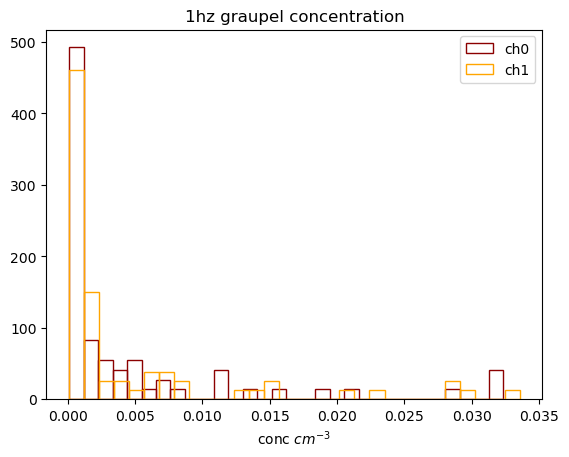

In [3]:
# make a histogram plot of graupel concentration (using simplest code possible) (no need to subset yet?)<

## need to pull out only graupel images -> 'CP'
ch0_graupel = ch0_specif_pass[ch0_specif_pass['habit'] == 'CP']
ch1_graupel = ch1_specif_pass[ch1_specif_pass['habit'] == 'CP']


# for normal concentration, we need the total per second (i.e. not per bin width)
def sum_second(df):
    sec_list = df['second'].unique()
    new_row = []
    for second in sec_list:
        sec_df = df[df['second'] == second]
        mean_values = sec_df[['LWC', 'IWC', 'w', 'pres', 'alt', 'temp']].mean()
        sum_values = sec_df[['conc', 'dNdd']].sum()
        new_row.append({'second': second,
                        'habit': sec_df.iloc[0]['habit'],
                        'conc': sum_values['conc'],
                        'dNdd': sum_values['dNdd'],
                        'LWC': mean_values['LWC'],
                        'IWC': mean_values['IWC'],
                        'w': mean_values['w'],
                        'pres': mean_values['pres'],
                        'alt': mean_values['alt'],
                        'temp': mean_values['temp']})
    new_df = pd.DataFrame(new_row)
    return new_df

ch0_graupel_sec = sum_second(ch0_graupel)
ch1_graupel_sec = sum_second(ch1_graupel)

### now just quick plot of the concentrations
plt.hist(ch0_graupel_sec['conc'], bins=30,
        edgecolor='darkred', facecolor='none',label='ch0', density=True)

plt.hist(ch1_graupel_sec['conc'], bins=30,
        edgecolor='orange', facecolor='none',label='ch1', density=True)

plt.title('1hz graupel concentration')
plt.legend()
plt.xlabel('conc $cm^{-3}$')


In [4]:
# need to bin into 10 sec intervals, 
ch0_graupel_sec#.to_csv('silly_little_ch0.csv')

,second,habit,conc,dNdd,LWC,IWC,w,pres,alt,temp
0,2022-07-30 17:00:11,CP,0.000400,0.000040,1.061989,0.000000,4.764501,503.288570,5851.218000,265.964630
1,2022-07-30 17:00:12,CP,0.000429,0.000043,1.251485,0.000000,4.764501,503.288570,5851.218000,265.964630
2,2022-07-30 17:00:14,CP,0.000532,0.000053,0.971063,0.000000,3.231000,503.472930,5850.613000,265.665900
3,2022-07-30 17:00:20,CP,0.000912,0.000091,0.629883,0.000000,-1.755500,503.028035,5853.623750,265.919000
4,2022-07-30 17:00:27,CP,0.000626,0.000063,0.371992,0.004945,2.641000,503.314330,5851.057600,266.619750
...,...,...,...,...,...,...,...,...,...,...
63,2022-07-30 17:15:28,CP,0.031928,0.003193,0.065474,0.587915,0.152971,462.780151,6506.542305,261.839190
64,2022-07-30 17:15:29,CP,0.028753,0.002875,0.084713,0.533096,0.884068,462.876257,6505.564072,262.016728
65,2022-07-30 17:15:30,CP,0.018949,0.001895,0.092274,0.412370,0.204704,462.840211,6504.840412,262.236999
66,2022-07-30 17:15:31,CP,0.008052,0.000805,0.101652,0.243512,-0.456943,462.904789,6503.512981,262.367704


In [54]:
ch0_graupel_sec['second'] = pd.to_datetime(ch0_graupel_sec['second'])
ch0_graupel_sec = ch0_graupel_sec.set_index('second')


KeyError: 'second'

In [76]:
'''
non_habit_ch0 = ch0_graupel_sec[['conc', 'dNdd', 'LWC', 'IWC', 'w', 'pres', 'alt']]

binned = non_habit_ch0.resample('10S')
counts = binned.size()
result = binned.mean().loc[counts]


ch0_graupel_sec['second'] = pd.to_datetime(ch0_graupel_sec['second'])
ch0_graupel_sec = ch0_graupel_sec.set_index('second')

# Bin into 10-sec intervals 
binned = ch0_graupel_sec.resample('10S').mean(numeric_only=True) # also need to drop the habit column

# Fill empty bins with 0
binned = binned.fillna(0)
'''


/tmp/ipykernel_5047/674606642.py:13: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  binned = ch0_graupel_sec.resample('10S').mean(numeric_only=True)


In [15]:

# getting average in-situ obs over 10s - also accounting for 0 values in 10s
def average_10s(inst_df, pass_numbers, pass_times):
    average_list = []
    for j in pass_numbers:
        start = pd.to_datetime(pass_times[str(j)]['start'])
        end = pd.to_datetime(pass_times[str(j)]['end'])
        # only want whole 10s in cloud
        start_10s = start.ceil('10s') # when averaging, only average in cloud time
        end_10s = end.floor('10s') - pd.Timedelta(seconds=1)
    
        whole_10s_pass = inst_df[(inst_df['second'] >= start_10s) & (inst_df['second'] <= end_10s)]
        
        full_index = pd.date_range(start=start_10s, end=end_10s, freq='1s') # capture all seconds in start / end of pass
        whole_10s_pass = whole_10s_pass.set_index('second')
        whole_10s_pass = whole_10s_pass.reindex(full_index) # full df of seconds from pass 
        # fill in nan values with 0 
        whole_10s_pass.fillna(0, inplace=True)
    
        # drop habit column (we know we're only dealing with CP)
        whole_10s_pass.drop(columns=['habit'], inplace=True)
        
        # Resample into 10-second bins + calculate mean
        df_10s = whole_10s_pass.resample('10s').mean()
        average_list.append(df_10s)
    
    average_10s_df = pd.concat(average_list)
    return average_10s_df

In [22]:
ch0_10s = average_10s(ch0_graupel_sec, pass_numbers, pass_times)
ch1_10s = average_10s(ch1_graupel_sec, pass_numbers, pass_times)


# for histogram, best just drop 0 values for conc
ch0_10s_non_0 = ch0_10s[ch0_10s['conc'] != 0]
ch1_10s_non_0 = ch1_10s[ch1_10s['conc'] != 0]

Text(0.5, 0, 'conc $cm^{-3}$')

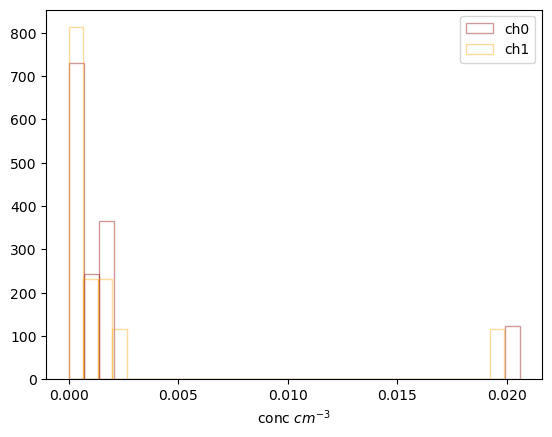

In [26]:
ch0_color = 'darkred'
ch1_color = 'orange'
plt.hist(ch0_10s_non_0['conc'], bins=30,edgecolor=ch0_color,  facecolor='none', alpha=0.4,
             label=f'ch0', density=True)
plt.hist(ch1_10s_non_0['conc'], bins=30, edgecolor=ch1_color, facecolor='none', alpha=0.4,
             label=f'ch1', density=True)

plt.title('0.1hz graupel concentration')
plt.legend()
plt.xlabel('conc $cm^{-3}$')
#plt.xscale('log')
#plt.yscale('log')


Text(0.5, 0, 'conc $cm^{-3}$')

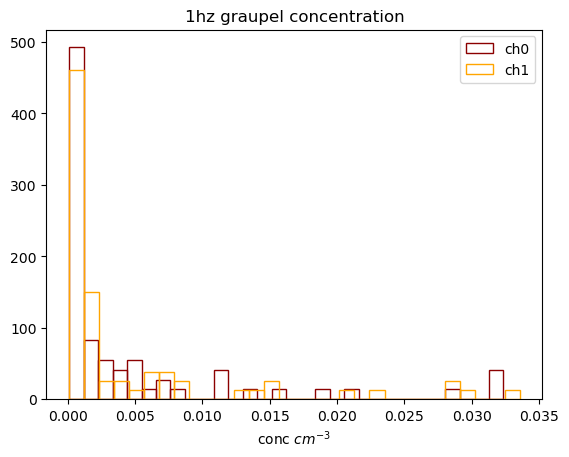

In [25]:
### now just quick plot of the concentrations
plt.hist(ch0_graupel_sec['conc'], bins=30,
        edgecolor='darkred', facecolor='none',label='ch0', density=True)

plt.hist(ch1_graupel_sec['conc'], bins=30,
        edgecolor='orange', facecolor='none',label='ch1', density=True)

plt.title('1hz graupel concentration')
plt.legend()
plt.xlabel('conc $cm^{-3}$')

### regrid + save nc file
for density files, they are on slightly wrong grid

In [2]:
# need to make the re-gridder base on hydro + density file - then can be applied to others
base_loc = '/gws/nopw/j04/dcmex/users/dfinney/data/CASIM/dd455_4apr2024_ncs_27feb2025v2/20220730T0000Z/expt3/'
# hydro file - correct grid 
a_og_hydro_file = xr.load_dataset(f'{base_loc}20220730T0000Z_LMagda_km1p5set1_expt3_pz015.nc',  decode_timedelta=True) 
a_density_file = xr.load_dataset(f'{base_loc}20220730T0000Z_LMagda_km1p5set1_expt3_pz015_density.nc',  decode_timedelta=True)

#regridder = xe.Regridder(file_to_change, file_correct_grid, "bilinear")
regridder = xe.Regridder(a_density_file, a_og_hydro_file, "bilinear")


In [9]:
time = '21'
density_file = xr.load_dataset(f'{base_loc}20220730T0000Z_LMagda_km1p5set1_expt3_pz0{time}_density.nc',  decode_timedelta=True)
corrected_density = regridder(density_file)
save_loc = '/gws/ssde/j25a/unrisk/workshop_fieldcampaigns_finney/Materials/model/extra_experiment/'
#corrected_density.to_netcdf(f'{save_loc}20220730T0000Z_LMagda_km1p5set1_expt3_pz0{time}_density.nc')
print('done!')

done!
